# Exercises

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson
import pickle
import random
from tqdm import tqdm

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

In [2]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [3]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [4]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [5]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [6]:

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [7]:
len(x)

4366

In [8]:
sample_sz_lst = np.arange(250,len(x),250)
indices = np.arange(0,len(x), 1)

median_errors = []

for sample_sz in sample_sz_lst:
    sample_indices = np.random.choice(indices, sample_sz, False)
    sample_indices = np.sort(sample_indices)
    x_sample = x[sample_indices]
    t_sample = t[sample_indices]
        
    spike_positions = [np.interp(s, t_sample, x_sample) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)
        
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x_sample, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t_sample)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    true_x = x_sample[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t_sample[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    mse = np.sqrt((true_x-x_decoded)**2)
    median_errors.append(np.nanmedian(mse))

100%|██████████████████████████████████████| 4249/4249 [00:19<00:00, 219.94it/s]


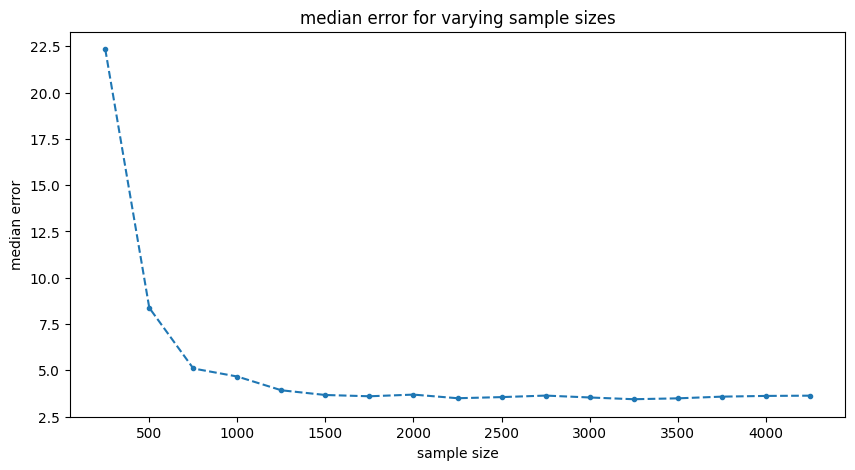

In [9]:
plt.plot(sample_sz_lst, median_errors, '.--')
plt.title('median error for varying sample sizes')
plt.xlabel('sample size')
plt.ylabel('median error')
plt.show()

So as to be expected the error goes down for higher sample size. After around 1750 as sample size it doesn't really go down anymore.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

In [10]:
sample_sz_lst = np.arange(10,n_cells+1,10)
indices = np.arange(0,n_cells, 1)

median_errors = []

for sample_sz in sample_sz_lst:
    #sample_indices = np.random.choice(indices, sample_sz, False)
    #sample_indices = np.sort(sample_indices)
    #print(sample_indices)
    x_sample = x
    t_sample = t
    
    #spikes_sample = spikes[sample_indices]
    
    spike_positions = [np.interp(s, t_sample, x_sample) for s in spikes[:sample_sz]]
    space_bins = np.arange(0., track_length, 5.)
        
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x_sample, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t_sample)[0] for s in spikes[:sample_sz]]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    true_x = x_sample[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t_sample[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    mse = np.sqrt((true_x-x_decoded)**2)
    median_errors.append(np.nanmedian(mse))

100%|██████████████████████████████████████| 4365/4365 [00:23<00:00, 183.32it/s]


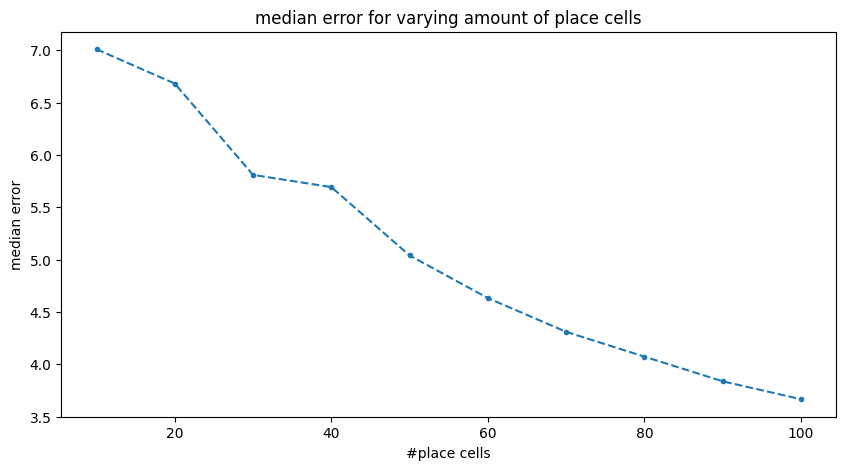

In [11]:
plt.plot(sample_sz_lst, median_errors, '.--')
plt.title('median error for varying amount of place cells')
plt.xlabel('#place cells')
plt.ylabel('median error')
plt.show()

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [12]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [13]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [14]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [15]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))

def spikes_func(noise_firing_rate=0.1):
    spikes = []

    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    return spikes

In [16]:
pwrs = np.arange(-2,1.1,0.2)
median_errors = []

for pwr in tqdm(pwrs):
    noise = 10**pwr
    spikes = spikes_func(noise)
    
    spike_positions = [np.interp(s, t_sample, x_sample) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)
        
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x_sample, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t_sample)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    true_x = x_sample[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t_sample[:-1]

    x_decoded = np.zeros_like(true_x)

    for t_bin in range(len(decoding_times)):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    mse = np.sqrt((true_x-x_decoded)**2)
    median_errors.append(np.nanmedian(mse))

100%|███████████████████████████████████████████| 16/16 [14:27<00:00, 54.21s/it]


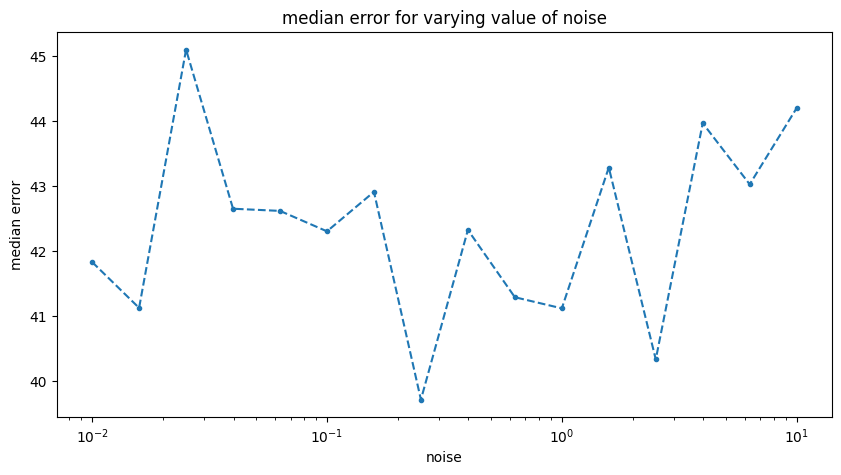

In [17]:
plt.plot(pow(10,pwrs), median_errors, '.--')
plt.xscale('log')
plt.title('median error for varying value of noise')
plt.xlabel('noise')
plt.ylabel('median error')
plt.show()

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




In [20]:
sample_sz_lst = np.arange(250,len(x),250)
indices = np.arange(0,len(x), 1)

median_errors1 = []
median_errors2 = []

for sample_sz in sample_sz_lst:
    sample_indices = np.random.choice(indices, sample_sz, False)
    sample_indices = np.sort(sample_indices)
    x_sample = x[sample_indices]
    t_sample = t[sample_indices]
        
    spike_positions = [np.interp(s, t_sample, x_sample) for s in spikes]
    space_bins = np.arange(0., track_length, 5.)
        
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x_sample, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t_sample)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

    true_x = x_sample[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t_sample[:-1]

    x_decoded1 = np.zeros_like(true_x)
    x_decoded2 = np.zeros_like(true_x)

    for t_bin in tqdm(range(len(decoding_times))):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior1 = np.empty(firing_rate_maps.shape[-1])
            posterior2 = np.empty(firing_rate_maps.shape[-1])

            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                posterior1[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
                posterior2[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))


            x_decoded1[t_bin] = space_bins[np.argmax(posterior1)]
            x_decoded2[t_bin] = space_bins[np.argmax(posterior2)]
        else:
            x_decoded1[t_bin] = np.nan
            x_decoded2[t_bin] = np.nan

    mse1 = np.sqrt((true_x-x_decoded1)**2)
    median_errors1.append(np.nanmedian(mse1))
    
    mse2 = np.sqrt((true_x-x_decoded2)**2)
    median_errors2.append(np.nanmedian(mse2))

100%|███████████████████████████████████████| 4749/4749 [01:08<00:00, 69.21it/s]


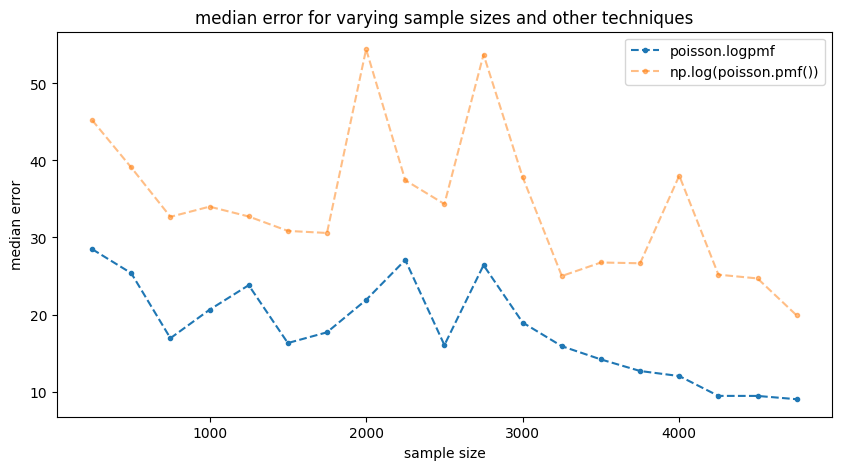

In [21]:
plt.plot(sample_sz_lst, median_errors1, '.--', label='poisson.logpmf')
plt.plot(sample_sz_lst, median_errors2, '.--', alpha = 0.5, label='np.log(poisson.pmf())')
plt.title('median error for varying sample sizes and other techniques')
plt.xlabel('sample size')
plt.ylabel('median error')
plt.legend()
plt.show()

So we see that the new method has a bigger error than the old one which is as expected.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation